# Subduction kinematics

Extract subduction zone information from the [Clennett _et al._ (2010)](https://doi.org/10.1029/2020GC009117) plate model.

#### References

Clennett, E. J., Sigloch, K., Mihalynuk, M. G., Seton, M., Henderson, M. A., Hosseini, K., et al. (2020). A Quantitative Tomotectonic Plate Reconstruction of Western North America and the Eastern Pacific Basin. Geochemistry, Geophysics, Geosystems, 21(8), 1–25. https://doi.org/10.1029/2020GC009117

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pygplates
import gplately
import os, glob

extent_globe = [-180, 180, -90, 90]

In [2]:
# Call GPlately's DataServer object and download the plate model
gdownload = gplately.download.DataServer("Clennett2020")
# rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# overwrite with more recent reconstructions
input_directory = "data/Global_Model_WD_Internal_Release_2019_v2_Clennett_NE_Pacific/"
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"
static_polygons = input_directory+"StaticGeometries/StaticPolygons/Clennett_2020_StaticPolygons.gpml"
COBs = input_directory+"StaticGeometries/COBLineSegments/Global_EarthByte_GeeK07_COBLineSegments_2019_v1.gpmlz"

topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
# coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

## Get kinematic data

In [3]:
reconstruction_time = 0
tessellation_threshold_radians = np.deg2rad(0.5)

# calculate subduction convergence
subduction_data = model.tesselate_subduction_zones(reconstruction_time,
                                                   tessellation_threshold_radians,
                                                   ignore_warnings=True,
                                                   output_subducting_absolute_velocity_components=True,
                                                   velocity_delta_time=10)

# mask "negative" subduction rates
# subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
# subduction_data = subduction_data[subduction_convergence >= 0]

subduction_lon         = subduction_data[:,0]
subduction_lat         = subduction_data[:,1]
subduction_vel         = subduction_data[:,2]*1e-2
subduction_angle       = subduction_data[:,3]
subduction_norm        = subduction_data[:,7]
subduction_pid_sub     = subduction_data[:,8]
subduction_pid_over    = subduction_data[:,9]
subduction_length      = np.deg2rad(subduction_data[:,6]) * gplately.EARTH_RADIUS * 1e3 # in metres
subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
subduction_migration   = np.fabs(subduction_data[:,4])*1e-2 * np.cos(np.radians(subduction_data[:,5]))
subduction_plate_vel   = subduction_data[:,10]*1e-2

subduction_convergence = np.clip(subduction_convergence, 0, 1e99)

# sample seafloor age grid at subduction zones
age_grid = gdownload.get_age_grid(0)
age_raster = gplately.Raster(array=age_grid, extent=extent_globe)
age_raster.fill_NaNs(overwrite=True)
age_interp = age_raster.interpolate(subduction_lon, subduction_lat)

# calculate plate thickness from seafloor age
plate_thickness = gplately.tools.plate_isotherm_depth(age_interp)

# calculate subduction volume rate - m * m * m/yr
subduction_vol_rate = plate_thickness*subduction_length*subduction_convergence # integrated along subduction len
subduction_vol_rate *= 1e-9 # convert m^3/yr to km^3/yr

vratio = (subduction_convergence + subduction_migration)/(subduction_convergence + 1e-22)
vratio[subduction_plate_vel < 0] *= -1
vratio = np.clip(vratio, 0, 1)

subduction_flux = plate_thickness * subduction_convergence


print("mean plate thickness = {:.2f} m".format(plate_thickness.mean()))
print("mean subduction segment length = {:.2f} m".format(subduction_length.mean()))
print("mean subduction convergence rate = {:.4f} m/yr".format(subduction_convergence.mean()))
print("mean subduction volume rate = {:.4f} km^3/yr".format(subduction_vol_rate.mean()))
print("total subduction volume rate = {:.4f} km^3/yr".format(subduction_vol_rate.sum()))

Checking whether the requested files need to be updated...
Requested files are up-to-date!
mean plate thickness = 74578.30 m
mean subduction segment length = 40719.72 m
mean subduction convergence rate = 0.0394 m/yr
mean subduction volume rate = 0.1189 km^3/yr
total subduction volume rate = 189.4506 km^3/yr


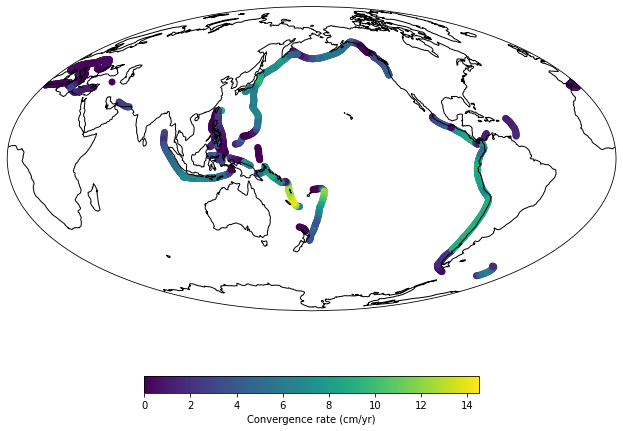

In [4]:
proj = ccrs.Mollweide(central_longitude=180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

sc = ax.scatter(subduction_lon, subduction_lat, c=subduction_convergence*100, transform=ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(sc, orientation='horizontal', shrink=0.4, label='Convergence rate (cm/yr)')



Project points along the subduction normal vector to sample slab dip from the Slab2 model.

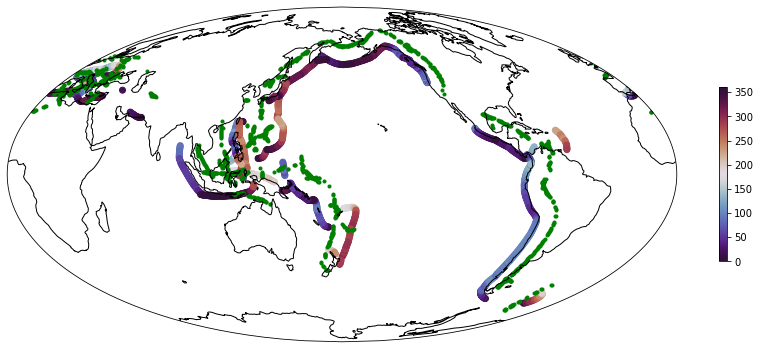

In [5]:
proj = ccrs.Mollweide(central_longitude=180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

sc = ax.scatter(subduction_lon, subduction_lat, c=subduction_norm, vmin=0, vmax=360,
                cmap='twilight_shifted', transform=ccrs.PlateCarree())

dlon = 10*np.sin(np.radians(subduction_norm))
dlat = 10*np.cos(np.radians(subduction_norm))
slon = subduction_lon + dlon
slat = subduction_lat + dlat

ax.scatter(slon, slat, c='g', marker='.', transform=ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(sc, shrink=0.4)

## Evaluate depth-distance relationships

Project points perpendicular to the subduction boundary segment in convergence direction, and sample Slab2 dip grid along these points.

In [6]:
# create slab dip raster
slab2_raster = gplately.Raster(filename='data/Slab2_compiled_dip.nc')

# choose number of steps over which to calculate slab dip
n_segs = len(subduction_lon)
n_steps = 82
dres = np.radians(10.0)

slab_dip = np.zeros((n_steps, n_segs))

# first row will be zeros
for i in range(1, n_steps):
    dlon = dres*i*np.sin(np.radians(subduction_norm))
    dlat = dres*i*np.cos(np.radians(subduction_norm))
    
    # sample dip from Slab2 raster
    ilon = subduction_lon + dlon
    ilat = subduction_lat + dlat
    
    slab_dip[i] = slab2_raster.interpolate(ilon, ilat)
    
slab_dip = np.nanmean(slab_dip[1:], axis=0)

print("No dip information for {} out of {} points".format(np.count_nonzero(np.isnan(slab_dip)), slab_dip.size))

No dip information for 464 out of 1594 points


/var/folders/cw/2gdtjqwj6f9blylnp_6wxgvh0000gn/T/ipykernel_10448/941974907.py:22: RuntimeWarning: Mean of empty slice
  slab_dip = np.nanmean(slab_dip[1:], axis=0)


## Plot slab dip

Be aware that this is slab dip from the __trench hinge__.

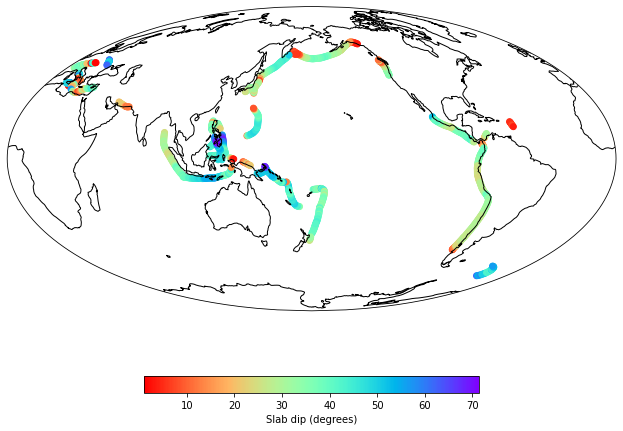

In [7]:
proj = ccrs.Mollweide(central_longitude=180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

sc = ax.scatter(subduction_lon, subduction_lat, c=slab_dip, cmap='rainbow_r',  transform=ccrs.PlateCarree())


ax.coastlines()
fig.colorbar(sc, shrink=0.4, orientation='horizontal', label='Slab dip (degrees)')

(array([ 45.,  56.,  41., 204., 230., 264., 172.,  86.,  21.,  11.]),
 array([ 1.06192088,  8.09392988, 15.12593889, 22.1579479 , 29.18995691,
        36.22196591, 43.25397492, 50.28598393, 57.31799294, 64.35000194,
        71.38201095]),
 <BarContainer object of 10 artists>)

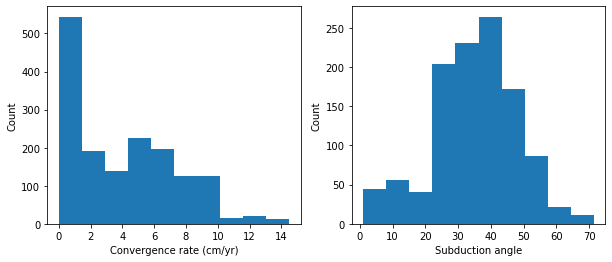

In [8]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,2,1, xlabel='Convergence rate (cm/yr)', ylabel='Count')
ax1.hist(subduction_convergence*100)

ax1 = fig.add_subplot(1,2,2, xlabel='Subduction angle', ylabel="Count")
ax1.hist(slab_dip)

## Save data

... to a pandas dataframe then output as a CSV file.

In [9]:
import pandas as pd


output_data = np.column_stack([
    subduction_lon,
    subduction_lat,
    subduction_angle,
    subduction_norm,
    subduction_pid_sub,
    subduction_pid_over,
    subduction_length,
    subduction_vel,
    subduction_convergence,
    subduction_migration,
    subduction_plate_vel,
    subduction_flux,
    age_interp,
    plate_thickness,
    vratio,
    slab_dip
])

header = ['lon', 'lat', 'angle', 'norm', 'pid_sub', 'pid_over', 'length', 
          'total_vel', 'vel', 'trench_vel', 'slab_vel_abs',
          'slab_flux', 'slab_age', 'slab_thickness','vratio', 'slab_dip']

df = pd.DataFrame(output_data, columns=header)
df.to_csv('data/subduction_data.csv')